# Introduction to Pytorch

Albert Bifet (@abifet)

<br>
<br>
<br>

![Taiao](img/TAIAO.jpg)

## Motivation

* Deep Learning using Python
  * accelerates the path from research prototyping to production deployment
  * uses a dynamic computation graph approach
  * uses hardware accelerators as GPUs
  
![PyTorch](img/Pytorch.png)
  
  

## Deep Learning

Inspired in biological neural networks

<img src="img/Neuron.png" width="800"/>

![ArtNeuron](img/artificial_neuron.png)

## Deep Learning

Inspired in biological neural networks

<img src="img/Neuron2.jpeg" width="800"/>
<img src="img/NN.jpeg" width="500"/>

## Deep Learning

Inspired in biological neural networks

<img src="img/Deep_Learning.jpg" width="800"/>

## Deep Learning

https://playground.tensorflow.org/


![Playground](img/Playground.png)


## Tensors 

Pytorch is targeted at two sets of audiences:

 * a replacement for NumPy to use the power of GPUs
 * a deep learning research platform that provides flexibility and speed



In [15]:
import torch

x = torch.rand(5, 3)
print(x)

tensor([[0.9071, 0.8981, 0.3579],
        [0.1911, 0.3069, 0.7893],
        [0.6700, 0.7616, 0.5970],
        [0.8152, 0.9668, 0.9442],
        [0.4322, 0.6822, 0.8882]])


## Stochastic Gradient Descent

weight = weight - learning_rate * gradient

![sgd](img/sgd.png)


## Gradient Computation


Gradient is computed automatically by the **autograd** Automatic Differentiation package.
 
Example: Gradient of $x^2$ is $2x$.


In [12]:
import torch
def f(x): return (x**2).sum()

xt = torch.tensor([1.,2.,3.]).requires_grad_()
yt = f(xt)

yt.backward()
print (xt.grad)

tensor([2., 4., 6.])


## Skcorch

A scikit-learn compatible neural network library that wraps PyTorch.


![skorch](img/skorch.png)

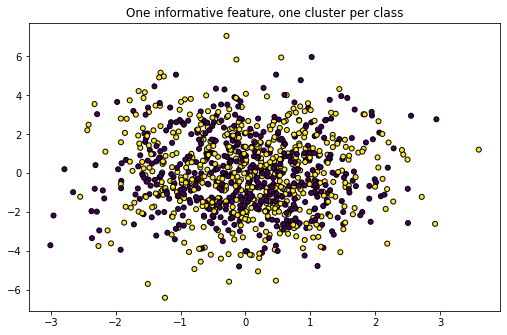

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

plt.figure(figsize=(16, 16))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)
plt.subplot(321)
plt.title("One informative feature, one cluster per class")
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

plt.show()

In [35]:
from torch import nn
import torch.nn.functional as F

class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=1)
        return X

In [38]:
from skorch import NeuralNetClassifier
net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(X, y)
y_proba = net.predict_proba(X)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6977       0.5350        0.6639  0.0188
      2        0.6705       0.6150        0.6508  0.0223
      3        0.6370       0.6750        0.6372  0.0253
      4        0.6409       0.6850        0.6266  0.0229
      5        0.6357       0.6750        0.6174  0.0198
      6        0.6161       0.6850        0.6066  0.0216
      7        0.6178       0.6900        0.6025  0.0190
      8        0.5898       0.7050        0.5935  0.0209
      9        0.5803       0.7100        0.5862  0.0207
     10        0.5796       0.7100        0.5827  0.0183


# PyTorch Example

## MNIST Dataset

The MNIST database (National Institute of Standards and Technology database) is a large of handwritten digits that is commonly used for training various image processing systems.

It contains 60,000 training images and 10,000 testing images.

![numbers](img/numbers.png)

## Pytorch Data Loading

In [15]:
import torch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Conv2d, Linear, Flatten
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

# Download the MNIST Data and create dataloader
transform = transforms.Compose([transforms.ToTensor()])
xy_train = datasets.MNIST('./', download=True, train=True, transform=transform)
xy_test = datasets.MNIST('./', download=True, train=False, transform=transform)

train_ds = DataLoader(xy_train, batch_size=32, shuffle=True)
test_ds = DataLoader(xy_test, batch_size=32, shuffle=True)


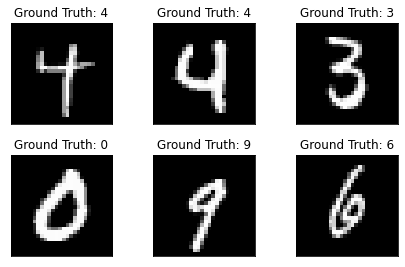

In [17]:
import matplotlib.pyplot as plt
examples = enumerate(test_ds)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Pytorch Model

In [19]:
# Model Definition
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.flatten = Flatten()
        self.d1 = Linear(21632, 128)
        self.d2 = Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.flatten(x)
        x = F.relu(self.d1(x))
        x = self.d2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Evaluate Training Loss

In [28]:
# Instantiate Model, Optimizer, Loss
model = MyModel()
optimizer = Adam(model.parameters())
loss_object = CrossEntropyLoss(reduction='sum')

def train_model(model, optimizer, loss_object):
    model.train()
    train_loss = 0
    train_n = 0
    for image, labels in train_ds:
        predictions = model(image).squeeze()
        loss = loss_object(predictions, labels)
        train_loss += loss.item()
        train_n += labels.shape[0]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= train_n
    return train_loss

## Evaluate Testing Loss

In [29]:
def compute_test_loss(model, optimizer, loss_object):
    model.eval()
    test_loss = 0
    test_accuracy =0
    test_n = 0
    for batch_num, (test_images, test_labels) in enumerate(test_ds):
        test_predictions = model(test_images)
        t_loss = loss_object(test_predictions, test_labels)

        test_loss += t_loss.item()
        test_n += test_labels.shape[0]
        test_accuracy += (torch.argmax(test_predictions.data, 1) == test_labels).float().sum().item()

    test_accuracy /= test_n
    test_loss /= test_n
    return test_loss, test_accuracy

## Training and Evaluation

In [30]:
for epoch in range(2):
    # Train
    train_loss = train_model(model,optimizer, loss_object)

    # Evaluate Test accuracy
    test_loss, test_accuracy = compute_test_loss(model, optimizer, loss_object)

    # Calculate Loss / accuracy
    template = 'Epoch {}, Loss: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss,
                          test_loss,
                          test_accuracy * 100))

Epoch 1, Loss: 0.17852589980786046, Test Loss: 0.06871526444926858, Test Accuracy: 97.85000000000001
Epoch 2, Loss: 0.05410303262847786, Test Loss: 0.050762077813781795, Test Accuracy: 98.29


## Tensorflow

Tensorflow is a symbolic math library based on dataflow and differentiable programming. It is used for both research and production at Google.

![tensorflow](img/tensorflow.png)



## TensorFlow Model

In [ ]:
# Model Definition
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(filters=32, kernel_size=3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        output = self.d2(x)
        return output

## Pytorch Model

In [45]:
# Model Definition
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.flatten = Flatten()
        self.d1 = Linear(21632, 128)
        self.d2 = Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.flatten(x)
        x = F.relu(self.d1(x))
        x = self.d2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Thanks! 

# Introduction to Pytorch

Albert Bifet (@abifet)

<br>
<br>
<br>

![Taiao](img/TAIAO.jpg)